In [3]:
import pandas as pd
import re
from sklearn.feature_extraction.text import TfidfTransformer, TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import *
from textblob import Word
import nltk
#nltk.download('wordnet')
from imblearn.over_sampling import SMOTE
from sklearn.naive_bayes import MultinomialNB, BernoulliNB
from sklearn import svm
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
import pickle
import seaborn as sns
from nltk.stem import WordNetLemmatizer

lemmatizer = WordNetLemmatizer()

In [4]:
# Load the dataset
Review_data=pd.read_csv("sample30.csv")
Review_data

,id,brand,categories,manufacturer,name,reviews_date,reviews_didPurchase,reviews_doRecommend,reviews_rating,reviews_text,reviews_title,reviews_userCity,reviews_userProvince,reviews_username,user_sentiment
0,AV13O1A8GV-KLJ3akUyj,Universal Music,"Movies, Music & Books,Music,R&b,Movies & TV,Mo...",Universal Music Group / Cash Money,Pink Friday: Roman Reloaded Re-Up (w/dvd),2012-11-30T06:21:45.000Z,NaN,NaN,5,i love this album. it's very good. more to the...,Just Awesome,Los Angeles,NaN,joshua,Positive
1,AV14LG0R-jtxr-f38QfS,Lundberg,"Food,Packaged Foods,Snacks,Crackers,Snacks, Co...",Lundberg,Lundberg Organic Cinnamon Toast Rice Cakes,2017-07-09T00:00:00.000Z,True,NaN,5,Good flavor. This review was collected as part...,Good,NaN,NaN,dorothy w,Positive
2,AV14LG0R-jtxr-f38QfS,Lundberg,"Food,Packaged Foods,Snacks,Crackers,Snacks, Co...",Lundberg,Lundberg Organic Cinnamon Toast Rice Cakes,2017-07-09T00:00:00.000Z,True,NaN,5,Good flavor.,Good,NaN,NaN,dorothy w,Positive
3,AV16khLE-jtxr-f38VFn,K-Y,"Personal Care,Medicine Cabinet,Lubricant/Sperm...",K-Y,K-Y Love Sensuality Pleasure Gel,2016-01-06T00:00:00.000Z,False,False,1,I read through the reviews on here before look...,Disappointed,NaN,NaN,rebecca,Negative
4,AV16khLE-jtxr-f38VFn,K-Y,"Personal Care,Medicine Cabinet,Lubricant/Sperm...",K-Y,K-Y Love Sensuality Pleasure Gel,2016-12-21T00:00:00.000Z,False,False,1,My husband bought this gel for us. The gel cau...,Irritation,NaN,NaN,walker557,Negative
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
29995,AVpfW8y_LJeJML437ySW,L'oreal Paris,"Beauty,Hair Care,Shampoo & Conditioner,Holiday...",L'oreal Paris,L'or233al Paris Elvive Extraordinary Clay Reba...,2017-01-23T00:00:00.000Z,False,True,5,I got this conditioner with Influenster to try...,Softness!!,NaN,NaN,laurasnchz,Positive
29996,AVpfW8y_LJeJML437ySW,L'oreal Paris,"Beauty,Hair Care,Shampoo & Conditioner,Holiday...",L'oreal Paris,L'or233al Paris Elvive Extraordinary Clay Reba...,2017-01-27T00:00:00.000Z,False,True,5,"I love it , I received this for review purpose...",I love it,NaN,NaN,scarlepadilla,Positive
29997,AVpfW8y_LJeJML437ySW,L'oreal Paris,"Beauty,Hair Care,Shampoo & Conditioner,Holiday...",L'oreal Paris,L'or233al Paris Elvive Extraordinary Clay Reba...,2017-01-21T00:00:00.000Z,False,True,5,First of all I love the smell of this product....,Hair is so smooth after use,NaN,NaN,liviasuexo,Positive
29998,AVpfW8y_LJeJML437ySW,L'oreal Paris,"Beauty,Hair Care,Shampoo & Conditioner,Holiday...",L'oreal Paris,L'or233al Paris Elvive Extraordinary Clay Reba...,2017-01-11T00:00:00.000Z,False,True,5,I received this through Influenster and will n...,Perfect for my oily hair!,NaN,NaN,ktreed95,Positive


In [5]:
# Lets verify the Blank values
Review_data.count()

id                      30000
brand                   30000
categories              30000
manufacturer            29859
name                    30000
reviews_date            29954
reviews_didPurchase     15932
reviews_doRecommend     27430
reviews_rating          30000
reviews_text            30000
reviews_title           29810
reviews_userCity         1929
reviews_userProvince      170
reviews_username        29937
user_sentiment          29999
dtype: int64

In [6]:
# Update the sentiment values {Positive:1, Negative:0}
Review_data['user_sentiment']=Review_data['user_sentiment'].map({'Negative':0, 'Positive':1,})
# Because most of the reviews are positive, update the missing sentiment value to positive
Review_data['user_sentiment'] = Review_data.user_sentiment.fillna(1)
Review_data['user_sentiment']= Review_data['user_sentiment'].astype('int')
Review_data=Review_data[['reviews_text','user_sentiment']]
Review_data

,reviews_text,user_sentiment
0,i love this album. it's very good. more to the...,1
1,Good flavor. This review was collected as part...,1
2,Good flavor.,1
3,I read through the reviews on here before look...,0
4,My husband bought this gel for us. The gel cau...,0
...,...,...
29995,I got this conditioner with Influenster to try...,1
29996,"I love it , I received this for review purpose...",1
29997,First of all I love the smell of this product....,1
29998,I received this through Influenster and will n...,1


<AxesSubplot:xlabel='user_sentiment', ylabel='count'>

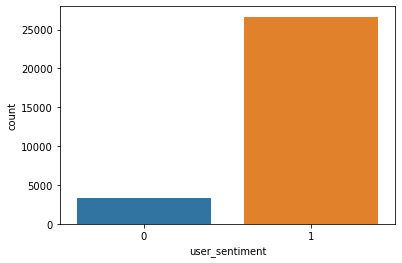

In [7]:
# Lets check the distribution of Positive and negative sentiments
sns.countplot(x='user_sentiment', data=Review_data)

# This chart shows that there is a huge difference between positive and negative datas count. So the data is balanced at later point.

In [8]:
# Define method for text filering

def text_process(text):
    # Remove digits
    text = re.sub(r'[0-9]', '', text)
    # Remove all the special characters
    text = re.sub(r'\W', ' ', text)
    # remove all single characters
    text = re.sub(r'\s+[a-zA-Z]\s+', ' ', text)
    # Remove single characters from the start
    text = re.sub(r'\^[a-zA-Z]\s+', ' ', text) 
    # Substituting multiple spaces with single space
    text= re.sub(r'\s+', ' ', text, flags=re.I)
    # Removing prefixed 'b'
    text = re.sub(r'^b\s+', '', text)
    text = text.lower()
    text=lemmatizer.lemmatize(text)
    return text

In [9]:
# Lets just use the user review's comment only for sentiment analysis 
X = Review_data['reviews_text']
Y = Review_data['user_sentiment']

In [10]:
X = X.apply(lambda x: text_process(x))
X = X.apply(lambda x: ' '.join([Word(word).lemmatize() for word in x.split()]))
X

0        i love this album it very good more to the hip...
1        good flavor this review wa collected a part of...
2                                              good flavor
3        i read through the review on here before looki...
4        my husband bought this gel for u the gel cause...
                               ...                        
29995    i got this conditioner with influenster to try...
29996    i love it received this for review purpose fro...
29997    first of all love the smell of this product af...
29998    i received this through influenster and will n...
29999    i received this product complimentary from inf...
Name: reviews_text, Length: 30000, dtype: object

In [11]:
# Define TfidfVectorizer
tfidf = TfidfVectorizer(max_features=1500, lowercase=True, analyzer='word', stop_words= 'english')

In [12]:
# Function for feature extraction and use different machine learning models on those features

def model_fit(X, y, feature_model,ml_model,coef_show=1):
    
    X_features = feature_model.fit_transform(X)
    print('# features: {}'.format(X_features.shape[1]))
    X_train, X_test, y_train, y_test = train_test_split(X_features, y, test_size = 0.2, random_state=45)
    clf = ml_model.fit(X_train, y_train)
    clf_pred = clf.predict(X_test)
    accuracy = clf.score(X_test, y_test)
    model_performance = classification_report(y_test, clf_pred)
    print ('accuracy of the model: ', accuracy)
    print('')
    print(model_performance)
    
    if coef_show == 1: 
        w = feature_model.get_feature_names()
        coef = clf.coef_.tolist()[0]
        coeff_df = pd.DataFrame({'Word' : w, 'Coefficient' : coef})
        coeff_df = coeff_df.sort_values(['Coefficient', 'Word'], ascending=[0, 1])
        print('')
        print('Top 10 positive features (variables)')
        print(coeff_df.head(20).to_string(index=False))
        print('')
        print('Top 10 negative features (variables)')        
        print(coeff_df.tail(20).to_string(index=False))

In [13]:
# Fit model using logistic regression

model_fit(X, Y, tfidf,LogisticRegression(),coef_show=1)

# features: 1500
accuracy of the model:  0.9206666666666666

              precision    recall  f1-score   support

           0       0.91      0.35      0.51       699
           1       0.92      1.00      0.96      5301

    accuracy                           0.92      6000
   macro avg       0.92      0.67      0.73      6000
weighted avg       0.92      0.92      0.90      6000


Top 10 positive features (variables)
      Word  Coefficient
     great    13.441715
      love     9.009180
      best     8.206093
      easy     7.823733
      good     7.548924
     clean     6.730321
     loved     5.789734
    better     5.534399
      nice     5.247802
 excellent     5.039316
   perfect     4.964008
   amazing     4.598320
   awesome     4.528715
   enjoyed     4.444107
  favorite     4.149565
      free     4.019181
 wonderful     3.785794
    really     3.609970
     fresh     3.488662
     handy     3.457102

Top 10 negative features (variables)
         Word  Coefficient
     

In [14]:
# Save the tfidf vectorizer reference for future usase.
pickle.dump(tfidf, open('tfidf.pkl', 'wb'))

In [15]:
# Lets verify the data balancing
Y.value_counts()

1    26633
0     3367
Name: user_sentiment, dtype: int64

In [16]:
X_features=tfidf.fit_transform(X)
X_train, X_test, y_train, y_test = train_test_split(X_features, Y, test_size = 0.2, random_state=45)

# Because there is a huge gap between positive and Negative sentiments, lets balance the data first 
sm = SMOTE()
X_train_smote, y_train_smote = sm.fit_sample(X_train, y_train)
X_test_smote, y_test_smote = sm.fit_sample(X_test, y_test)
y_train_smote.value_counts()

1    21332
0    21332
Name: user_sentiment, dtype: int64

In [17]:
y_test_smote.value_counts()

1    5301
0    5301
Name: user_sentiment, dtype: int64

In [18]:
# function to git the model for bslsnced data
def class_balanced_model_fit(X_train_smote, y_train_smote, X_test_smote, y_test_smote, ml_model,filename):
    
    clf = ml_model.fit(X_train_smote, y_train_smote)
    clf_pred = clf.predict(X_test_smote)
    accuracy = clf.score(X_test_smote, y_test_smote)
    model_performance = classification_report(y_test_smote, clf_pred)
    validation_pred_proba_grad = clf.predict_proba(X_test_smote)
    roc_auc = roc_auc_score(y_test_smote, validation_pred_proba_grad[:,1])
    pickle.dump(clf, open(filename, 'wb'))
    print ('accuracy of the model: ', accuracy)
    print('')
    print(model_performance)
    print('')
    print('ROC_AUC score: ', roc_auc)

In [19]:
# Using logistic regression
class_balanced_model_fit(X_train_smote, y_train_smote, X_test_smote, y_test_smote, LogisticRegression(),'lgregression.pkl')

accuracy of the model:  0.9316166760988492

              precision    recall  f1-score   support

           0       0.93      0.94      0.93      5301
           1       0.94      0.93      0.93      5301

    accuracy                           0.93     10602
   macro avg       0.93      0.93      0.93     10602
weighted avg       0.93      0.93      0.93     10602


ROC_AUC score:  0.9808938072178598


In [20]:
# Using Naivebyes (Using Multinomial)
class_balanced_model_fit(X_train_smote, y_train_smote, X_test_smote, y_test_smote, MultinomialNB(),'nvb_multinomial.pkl')

accuracy of the model:  0.8045651763818148

              precision    recall  f1-score   support

           0       0.84      0.75      0.79      5301
           1       0.78      0.86      0.81      5301

    accuracy                           0.80     10602
   macro avg       0.81      0.80      0.80     10602
weighted avg       0.81      0.80      0.80     10602


ROC_AUC score:  0.8889171267191047


In [21]:
# Using Nsivebyes (Bernoulli)
class_balanced_model_fit(X_train_smote, y_train_smote, X_test_smote, y_test_smote, BernoulliNB(),'nvb_bernoulli.pkl')

accuracy of the model:  0.822014714204867

              precision    recall  f1-score   support

           0       0.85      0.78      0.82      5301
           1       0.80      0.86      0.83      5301

    accuracy                           0.82     10602
   macro avg       0.82      0.82      0.82     10602
weighted avg       0.82      0.82      0.82     10602


ROC_AUC score:  0.8920009397663772


In [22]:
# Using RandomForest
classifier = RandomForestClassifier(n_estimators=100, random_state=0)
class_balanced_model_fit(X_train_smote, y_train_smote, X_test_smote, y_test_smote, classifier,'randomforest.pkl')

accuracy of the model:  0.899641577060932

              precision    recall  f1-score   support

           0       0.96      0.84      0.89      5301
           1       0.86      0.96      0.91      5301

    accuracy                           0.90     10602
   macro avg       0.91      0.90      0.90     10602
weighted avg       0.91      0.90      0.90     10602


ROC_AUC score:  0.9720112925698636


In [23]:
# Using XGBoot
class_balanced_model_fit(X_train_smote, y_train_smote, X_test_smote, y_test_smote, XGBClassifier(),'xgboost.pkl')

C:\Users\madsingh\Anaconda3\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[23:01:31] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
accuracy of the model:  0.9168081494057725

              precision    recall  f1-score   support

           0       0.92      0.91      0.92      5301
           1       0.91      0.92      0.92      5301

    accuracy                           0.92     10602
   macro avg       0.92      0.92      0.92     10602
weighted avg       0.92      0.92      0.92     10602


ROC_AUC score:  0.971923073816108


In [24]:
#Conclusion Now because the accuracy, ROC_AUC and other parameters score are better for Logistic regression than other Algorithms,So we would be using Logistic regression model for future usage.